## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `SBERT` + `Agglomerative Clustering` olacak.
 
Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
import re
import string

In [18]:
df = pd.read_csv('../../Datas/data.csv')
df.head()
df.sample(n=5)

,category,content
1036,Spor,2014-15 Türkiye Erkekler Hentbol Süper Ligi Tü...
817,Savaşlar,26 Eylül 2022 tarihinde TSİ 22.40-23.00 suları...
267,Doğal Afetler,1938 Kırşehir depremi 19 Nisan yerel saat ile ...
1266,Doğal Afetler,"Çırçır Yangını, 23 Ağustos 1908’de İstanbul Sa..."
237,Doğal Afetler,"1653 Doğu İzmir depremi, 23 Şubatta tahmini de..."


## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)


In [19]:
# Boş değerleri sil.
# Küçük harfe çevir.
# Noktalama ve sayıları temizle.
# Stopwords temizliği yap.
# Stemming bu projede opsiyonel
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

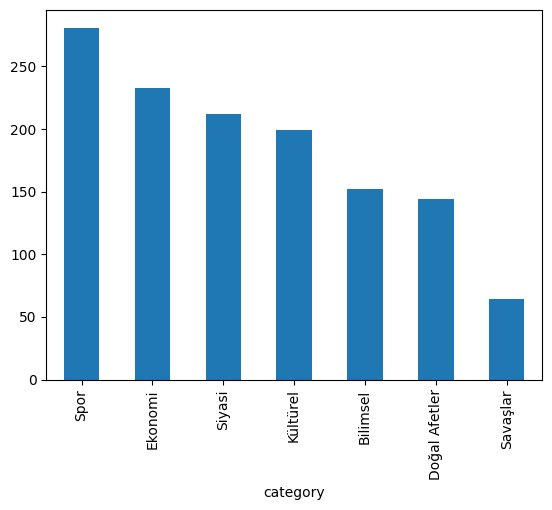

In [20]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [21]:
from sentence_transformers import SentenceTransformer

# Türkçe metinler için uygun, hızlı bir SBERT modeli:
sbert_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Embedding üretimi
X = sbert_model.encode(df['processed_data'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

In [22]:
from sklearn.cluster import AgglomerativeClustering

# Küme sayısı belirleyelim (örnek: 5)
# normalde 7 kategori var
num_clusters = 7

agglo = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X)

df['cluster'] = clusters

df[['category', 'cluster']].head()
df.sample(n=5)



,category,content,processed_data,cluster
1103,Spor,"657. Kırkpınar Yağlı Güreşleri, 2018 yılında E...",kırkpınar yağlı güreşleri yılında edirnede sar...,1
870,Siyasi,"1954 Türkiye genel seçimleri, 2 Mayıs 1954 tar...",türkiye genel seçimleri mayıs tarihinde tbmmde...,3
175,Bilimsel,Damson Cisor BT5 125 www.damsonaudio.com Dams...,damson cisor bt wwwdamsonaudiocom damson cisor...,6
571,Ekonomi,Türkiye 2000'li yılların sonlarına doğru küçük...,türkiye li yılların sonlarına doğru küçük çapt...,2
249,Doğal Afetler,"1872 Amik depremi veya 1872 Antakya depremi, 3...",amik depremi antakya depremi nisan tarihinde m...,0


In [23]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score

# Gerçek kategorileri sayısala dönüştür
le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

# Kümeleme sonuçları (senin clustering sonucu)
clusters = agglo.fit_predict(X)

cluster_label_map = {}

# Her cluster için en çok bulunan kategori sayısal kodunu bul
for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        print("Boş küme atlandı")
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    cluster_label_map[cluster_id] = most_common_num  # burada atama yapılmalı

# Sayısal kodları string kategori isimlerine dönüştür
cluster_label_map_str = {cluster_id: le.inverse_transform([num])[0] 
                        for cluster_id, num in cluster_label_map.items()}

# Tahmin edilen sayısal kategoriler (cluster'dan tahmin edilen kategori)
predicted_num_categories = np.array([cluster_label_map[c] for c in clusters])

# Sayısal kategorileri tekrar orijinal string label'a çevir
predicted_categories = le.inverse_transform(predicted_num_categories)

# Gerçek kategoriler
true_categories = df['category'].values

# Doğruluk ölçümü
accuracy = accuracy_score(true_categories, predicted_categories)

print(f"Cluster-label eşleştirilmiş doğruluk: {accuracy:.4f}")

print("Cluster - Gerçek kategori eşleşmeleri:")
for cid, cat in cluster_label_map_str.items():
    print(f"Cluster {cid} -> {cat}")


Cluster-label eşleştirilmiş doğruluk: 0.6654
Cluster - Gerçek kategori eşleşmeleri:
Cluster 0 -> Doğal Afetler
Cluster 1 -> Spor
Cluster 2 -> Siyasi
Cluster 3 -> Siyasi
Cluster 4 -> Spor
Cluster 5 -> Kültürel
Cluster 6 -> Ekonomi


In [24]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
from sklearn.metrics import accuracy_score

# Gerçek kategorileri sayısala dönüştür
le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

# Kümeleme sonuçları (senin clustering sonucu)
clusters = agglo.fit_predict(X)

cluster_label_map = {}

# Her cluster için en çok bulunan kategori sayısal kodunu bul
for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        print("Boş küme atlandı")
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    cluster_label_map[cluster_id] = most_common_num  # burada atama yapılmalı

# Sayısal kodları string kategori isimlerine dönüştür
cluster_label_map_str = {cluster_id: le.inverse_transform([num])[0] 
                        for cluster_id, num in cluster_label_map.items()}

# Tahmin edilen sayısal kategoriler (cluster'dan tahmin edilen kategori)
predicted_num_categories = np.array([cluster_label_map[c] for c in clusters])

# Sayısal kategorileri tekrar orijinal string label'a çevir
predicted_categories = le.inverse_transform(predicted_num_categories)

# Gerçek kategoriler
true_categories = df['category'].values

# Doğruluk ölçümü
accuracy = accuracy_score(true_categories, predicted_categories)

print(f"Cluster-label eşleştirilmiş doğruluk: {accuracy:.4f}")

print("Cluster - Gerçek kategori eşleşmeleri:")
for cid, cat in cluster_label_map_str.items():
    print(f"Cluster {cid} -> {cat}")


Cluster-label eşleştirilmiş doğruluk: 0.6654
Cluster - Gerçek kategori eşleşmeleri:
Cluster 0 -> Doğal Afetler
Cluster 1 -> Spor
Cluster 2 -> Siyasi
Cluster 3 -> Siyasi
Cluster 4 -> Spor
Cluster 5 -> Kültürel
Cluster 6 -> Ekonomi


In [ ]:
import joblib
import os

target_base_dir = '../../Models/SBERT'

# Modelin tam kaydedileceği yol
model_save_path = os.path.join(target_base_dir, 'agglo_model.joblib')

try:
    # Hedef dizini oluştur. exist_ok=True sayesinde zaten varsa hata vermez.
    os.makedirs(target_base_dir, exist_ok=True)
    print(f"'{target_base_dir}' dizini başarıyla oluşturuldu veya zaten mevcut.")
    print(f"Modelin kaydedileceği tam yol: {os.path.abspath(model_save_path)}") # Tam yolu gösterelim
except Exception as e:
    print(f"Dizin oluşturulurken bir hata oluştu: {e}")
    exit()


# Modeli kaydet
try:
    joblib.dump(agglo, model_save_path)
    print(f"Model '{model_save_path}' konumuna başarıyla kaydedildi.")
    joblib.dump(X, '../../Models/SBERT/embeddings.joblib')
    print(f"Embeddings '{model_save_path}' konumuna başarıyla kaydedildi.")
except Exception as e:
    print(f"Model kaydedilirken bir hata oluştu: {e}")

'../../Models/SBERT' dizini başarıyla oluşturuldu veya zaten mevcut.
Modelin kaydedileceği tam yol: c:\Users\uslan\OneDrive\Desktop\CENG Notes\3.Sınıf Dersleri\Machine Learning\Dejaview-CENG3522\Models\SBERT\agglo_model.joblib
Model '../../Models/SBERT\agglo_model.joblib' konumuna başarıyla kaydedildi.
Model '../../Models/SBERT\agglo_model.joblib' konumundan başarıyla yüklendi.
Yüklenen model içeriği: AgglomerativeClustering(n_clusters=7)


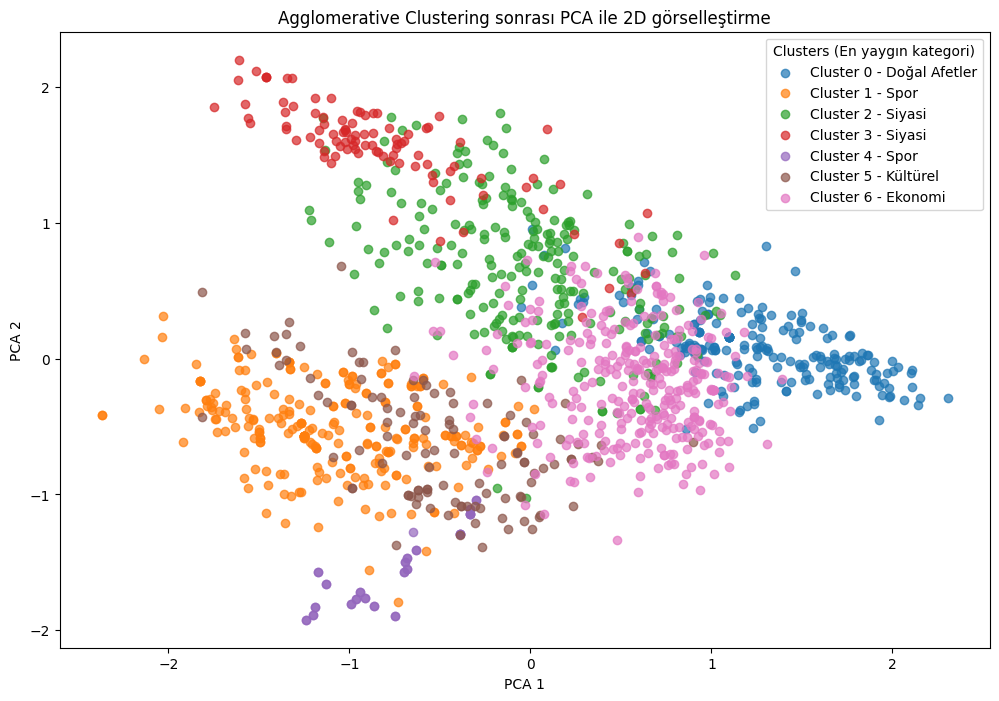

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

num_clusters = len(np.unique(clusters))
colors = plt.cm.tab10.colors

plt.figure(figsize=(12,8))

for cluster_id in range(num_clusters):
    idx = np.where(clusters == cluster_id)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], 
                color=colors[cluster_id % 10], 
                label=f"Cluster {cluster_id} - {cluster_label_map_str[cluster_id]}", 
                alpha=0.7)


plt.title('Agglomerative Clustering sonrası PCA ile 2D görselleştirme')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title="Clusters (En yaygın kategori)", loc='upper right')
plt.show()


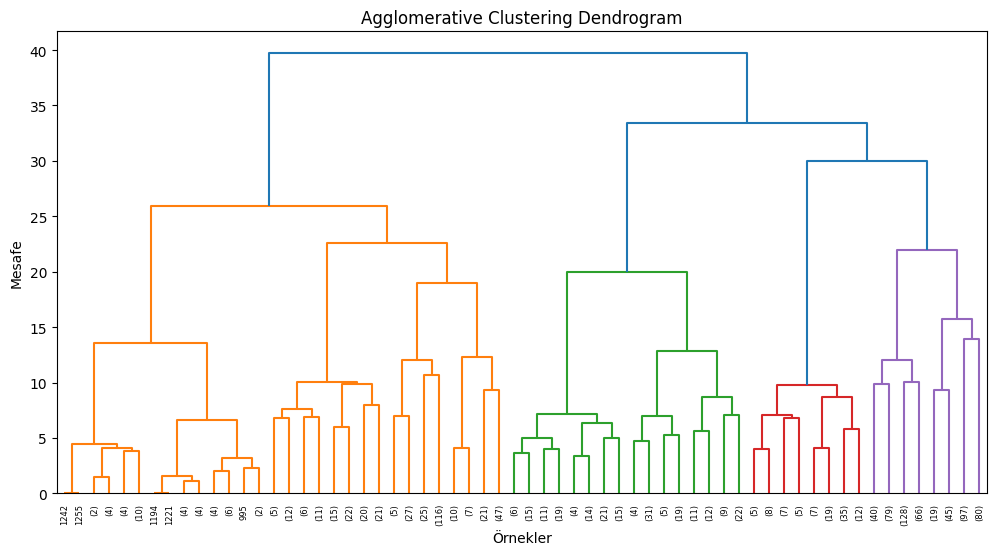

In [27]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # sadece ilk 5 seviyeyi gösterir
plt.title('Agglomerative Clustering Dendrogram')
plt.xlabel('Örnekler')
plt.ylabel('Mesafe')
plt.show()

## Grafik: Gerçek ve Tahmin Edilen Oranlar

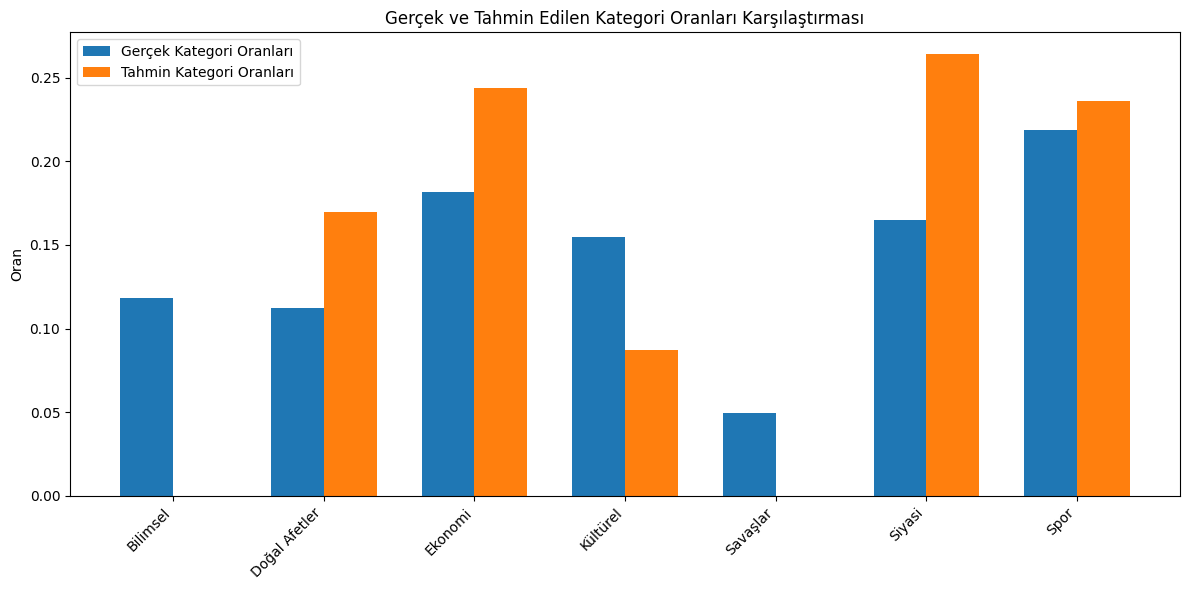

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Gerçek kategori oranları
true_counts = df['category'].value_counts(normalize=True).sort_index()

# Tahmin edilen kategori oranları
predicted_counts = pd.Series(predicted_categories).value_counts(normalize=True).sort_index()

# Tüm kategoriler (gerçek ve tahmin edilenlerde birleşik)
all_categories = sorted(set(true_counts.index).union(predicted_counts.index))

true_vals = [true_counts.get(cat, 0) for cat in all_categories]
predicted_vals = [predicted_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, true_vals, width, label='Gerçek Kategori Oranları')
rects2 = ax.bar(x + width/2, predicted_vals, width, label='Tahmin Kategori Oranları')

ax.set_ylabel('Oran')
ax.set_title('Gerçek ve Tahmin Edilen Kategori Oranları Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(all_categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()